# Training Deep Neural Networks on a GPU with PyTorch



In [8]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [9]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [10]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [11]:
batch_size=128

In [12]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


images.shape: torch.Size([128, 1, 28, 28])


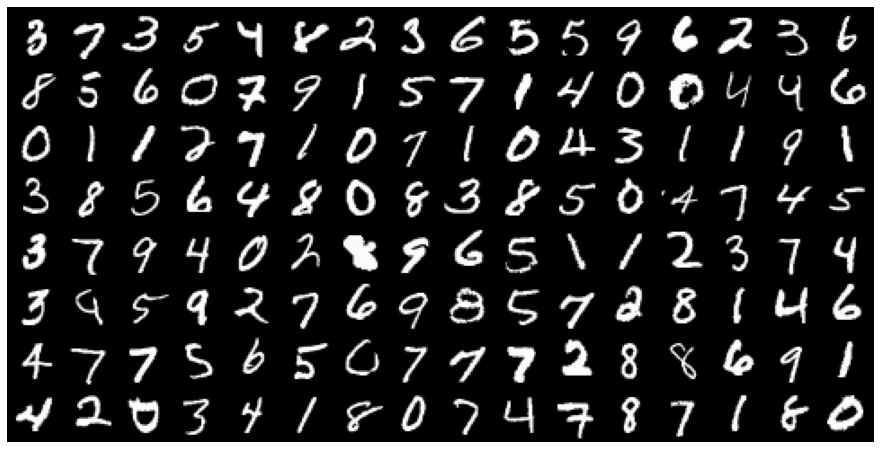

In [13]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model
We'll create a neural network with one **hidden layer**.:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a layer in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`, where `hidden_size` is a preconfigured parameter (e.g. 32 or 64).

* The intermediate outputs are then passed into a non-linear *activation function*, which operates on individual elements of the output matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size `batch_size x 10`, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. 
The activation function we'll use here is called a **Rectified Linear Unit** or **ReLU**, and it has a really simple formula: `relu(x) = max(0,x)` i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.



In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
input_size = 784
hidden_size = 32 
num_classes = 10

In [17]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [18]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [19]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.297731399536133
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0730, -0.2049, -0.1950,  0.1242,  0.0433,  0.0513,  0.0128,  0.0252,
         -0.2027, -0.0350],
        [ 0.0961, -0.0231, -0.1993,  0.2071,  0.0970, -0.1187, -0.0191, -0.0191,
         -0.1449, -0.0022]])


## Using a GPU



In [20]:
torch.cuda.is_available()

True

In [21]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [22]:
device = get_default_device()
device

device(type='cuda')

Move data and model to a chosen device.

In [23]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [24]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. All we need is an `__iter__` method to retrieve batches of data, and an `__len__` method to get the number of batches.

In [25]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using `DeviceDataLoader`.

In [26]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [27]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([7, 5, 1, 3, 7, 3, 8, 4, 7, 5, 0, 3, 6, 6, 5, 2, 4, 3, 2, 3, 5, 6, 8, 9,
        2, 5, 5, 9, 9, 6, 6, 9, 6, 3, 3, 4, 3, 2, 6, 7, 2, 9, 0, 0, 2, 3, 2, 8,
        1, 6, 8, 3, 5, 1, 1, 9, 4, 4, 7, 4, 6, 5, 7, 9, 3, 3, 5, 5, 9, 3, 7, 2,
        9, 8, 8, 3, 8, 8, 8, 5, 7, 2, 4, 0, 2, 7, 4, 9, 0, 7, 2, 5, 3, 4, 4, 2,
        5, 0, 3, 1, 7, 2, 6, 7, 1, 4, 1, 9, 2, 5, 3, 7, 9, 7, 9, 4, 6, 2, 2, 3,
        2, 0, 9, 4, 4, 9, 7, 5, 1, 4, 8, 1, 6, 2, 4, 8, 8, 7, 7, 2, 2, 2, 2, 0,
        8, 0, 0, 3, 1, 0, 5, 9, 8, 2, 1, 4, 7, 6, 0, 9, 3, 9, 4, 1, 6, 8, 2, 9,
        3, 6, 1, 5, 2, 5, 5, 0, 2, 0, 3, 4, 7, 3, 0, 1, 7, 9, 8, 2, 6, 9, 9, 9,
        8, 4, 4, 6, 0, 1, 0, 0, 4, 3, 0, 4, 2, 0, 7, 1, 9, 2, 3, 8, 4, 7, 0, 3,
        4, 5, 5, 3, 7, 3, 2, 4, 6, 1, 0, 1, 9, 7, 1, 1, 0, 4, 5, 4, 1, 1, 3, 1,
        6, 4, 2, 1, 7, 9, 3, 1, 4, 1, 3, 3, 9, 7, 2, 0], device='cuda:0')


## Training the Model

In [28]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit`.

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [29]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2439, val_acc: 0.9283
Epoch [1], val_loss: 0.2077, val_acc: 0.9336
Epoch [2], val_loss: 0.1875, val_acc: 0.9449
Epoch [3], val_loss: 0.1452, val_acc: 0.9564
Epoch [4], val_loss: 0.1340, val_acc: 0.9602


96% is pretty good! Let's train the model for 5 more epochs at a lower learning rate of 0.1, to further improve the accuracy.

In [32]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1222, val_acc: 0.9618
Epoch [1], val_loss: 0.1218, val_acc: 0.9633
Epoch [2], val_loss: 0.1211, val_acc: 0.9649
Epoch [3], val_loss: 0.1223, val_acc: 0.9632
Epoch [4], val_loss: 0.1185, val_acc: 0.9653


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

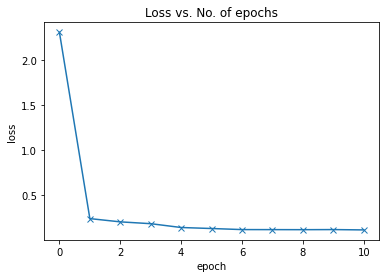

In [34]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

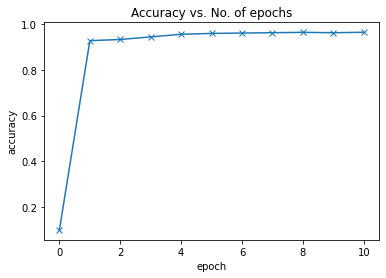

In [35]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');